In [1]:
def IterHessianSketch(A, y, m, maxIter, cons):
    """
    This function use iterative Hessian sketch to solve least square problem Ax=y.
    A, 2D array, n*d
    y, 1D array, length of n
    maxIter, maximal number of iterations 
    m, scalar, number of rows of sketch matrix S
    constr, equality and inequality constraints on x
    
    Algorithm:
    1. initialize x(0) = 0
    2. generate an independent sketch matrix S of size m*n
       x(t+1) = argmin_{x satisfies cons} { 1/2||SA(x-x(t))||_2^2 - < A^T(y-Ax(t)) , x >}
    3. return x(maxIter)
    
    Ref:
    Iterative Hessian Sketch: Fast and Accurate Solution Approximation for Constrained Least-Squares
    Mert Pilanci, Martin J. Wainwright
    http://www.jmlr.org/papers/volume17/14-460/14-460.pdf
    
    """
    import numpy as np
    from scipy.optimize import minimize

    sketch = np.random.randn
#     sketch = Sketch_ROS
    ATy = A.T.dot(y)
    ATA = A.T.dot(A)
    
    [row_A, col_A] = A.shape
    xt = np.zeros(col_A)
    xts = [xt]
    
    for t in range(maxIter):
        S = sketch(m,row_A)
        SA = S@A
        
        objective, gradient, hessian = SubOpt_HessianSketch(SA, ATA, ATy, xt)
        if cons is None:
            res = minimize(fun=objective, x0=np.zeros(col_A), jac=gradient)
        else:
            res = minimize(fun=objective, x0=np.zeros(col_A), jac=gradient, constraints=cons,
                       method='SLSQP')
        xt = res.x
        xts.append(np.copy(xt))
#         print(res.message)
    
    res.xt = xt
    res.xts = xts
    
    return res
        

In [2]:
def SubOpt_HessianSketch(SA, ATA, ATy, xt):
    """
    min_{x} 1/2 || SA(x-xt) ||_2^2 - <AT*y-ATA*xt,x>
    
    Returns:
    function
        objective function for `scipy.optimize.minimize`
    function
        gradient (jacobian) function for `scipy.optimize.minimize`
    function
        hessian function for `scipy.optimize.minimize`
    
    Ref:
    https://github.com/michaelerule/neurotools/blob/master/stats/glm.py
    GLMPenaltyL2
    """
    import numpy as np
    import numpy.linalg as LA
    
    m = SA.shape[0]
    def objective(x):
        objective = 1/2/m*LA.norm(SA@(x-xt),2)**2 - (ATy-ATA@xt)@(x)
        return objective        
        
    def gradient(x):
        gradient = 1/m*SA.T@SA@(x-xt) - (ATy-ATA@xt)
        return gradient        
        
    hessian = SA.T@SA
    
    return objective, gradient, hessian        
        
    

In [26]:
import numpy as np
import numpy.linalg as LA
import scipy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [4]:
# test: unconstrained least square sharpness
ds = [16, 32, 64, 128, 256]
for d in ds:
#     d = 32   # number of cols of A
    print("d=%d\n" %(d))
    n = int(100*d) # number of rows of A

    m = int(6*d) # sketch size
    N = 4    # number of Hessian sketch iterations

    A = np.random.randn(n,d)
    x_star = np.random.randn(d)
    x_star = x_star/LA.norm(x_star,2)
    y = A@x_star + np.random.randn(n)
    x_LS = LA.solve(A.T@A,A.T@y)
    x_hat = IterHessianSketch(A, y, m=m, maxIter=N, cons=None).xt   

    print("||x_LS-x_star||_A=%f\n" %(LA.norm(A@(x_LS-x_star),2)/np.sqrt(n)))
    print("||x_hat-x_star||_A=%f\n" %(LA.norm(A@(x_hat-x_star),2)/np.sqrt(n)))
#     print("||x_hat-x_LS||_A=%f\n" %(LA.norm(A@(x_hat-x_LS),2)/np.sqrt(n)))

d=16

||x_LS-x_star||_A=0.100502

||x_hat-x_star||_A=0.173523

d=32

||x_LS-x_star||_A=0.100410

||x_hat-x_star||_A=0.147769

d=64

||x_LS-x_star||_A=0.101210

||x_hat-x_star||_A=0.116636

d=128

||x_LS-x_star||_A=0.096684

||x_hat-x_star||_A=0.178544

d=256

||x_LS-x_star||_A=0.103736

||x_hat-x_star||_A=0.134899



||x_LS-x_star||_A=0.190136

||x_hat-x_star||_A=0.190057

||x_hat-x_LS||_A=0.000616



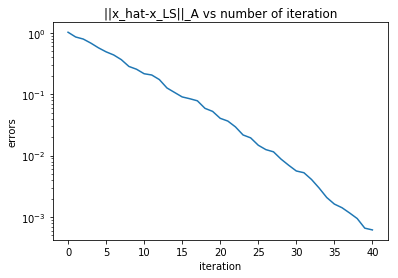

In [5]:
# test: unconstrained least square geometrically decay
d = 200   # number of cols of A
n = int(30*d) # number of rows of A

m = int(4*d) # sketch size
N = 40    # number of Hessian sketch iterations

A = np.random.randn(n,d)
x_star = np.random.randn(d)
x_star = x_star/LA.norm(x_star,2)
y = A@x_star + np.random.randn(n)
x_LS = LA.solve(A.T@A,A.T@y)

res = IterHessianSketch(A, y, m=m, maxIter=N, cons=None)
x_hat = res.xt
xts = res.xts

errors = np.zeros(len(xts))
for t in range(len(xts)):
    xt = xts[t]
    errors[t] = LA.norm(A@(xt-x_LS),2)/np.sqrt(n)

plt.figure()
plt.plot(errors)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title('||x_hat-x_LS||_A vs number of iteration')
plt.savefig("error_LS_un.pdf")


print("||x_LS-x_star||_A=%f\n" %(LA.norm(A@(x_LS-x_star),2)/np.sqrt(n)))
print("||x_hat-x_star||_A=%f\n" %(LA.norm(A@(x_hat-x_star),2)/np.sqrt(n)))
print("||x_hat-x_LS||_A=%f\n" %(LA.norm(A@(x_hat-x_LS),2)/np.sqrt(n)))

||x_LS-x_star||_A=0.095888

||x_hat-x_star||_A=0.094355

||x_hat-x_LS||_A=0.012839



Text(0.5, 1.0, '||x_hat-x_star||_A vs number of iteration')

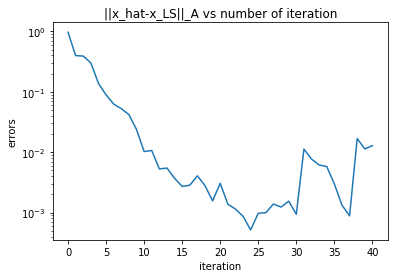

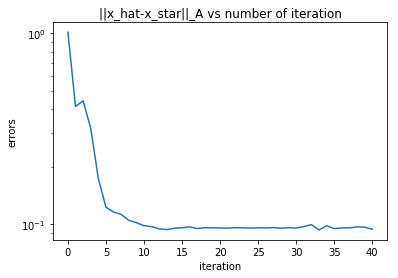

In [50]:
# sparse least-squares

d = 32   # number of cols of A
s = np.ceil(2*np.sqrt(d))   # sparsity of true vector x*
n = int(100*s*np.log(np.exp(1)*d/s)) # number of rows of A
m = int(4*s*np.log(np.exp(1)*d/s))  # sketch size
N = 40    # number of Hessian sketch iterations

# d = 256
# n = 8872
# s = 32
# gamma = 25
# m = int(np.ceil(gamma*s*np.log(d)))
# N = 15

A = np.random.randn(n,d)
x_star = sp.sparse.random(d,1, density=s/d).toarray().reshape(d)
x_star = x_star/LA.norm(x_star,2)
y = A@x_star + np.random.randn(n)
ATy = A.T@y
ATA = A.T@A

R = sum(abs(x_star))   # l1 norm constraint of x
cons_l1norm = ({'type': 'ineq', 'fun': lambda x:  R-sum(abs(x))})

objective = lambda x: 1/2*LA.norm(A@x,2)**2 - ATy@x
gradient = lambda x: ATA@x - ATy
hessian = ATA
res = minimize(fun=objective, x0=np.zeros(d), jac=gradient, constraints=cons_l1norm, method='SLSQP')
x_LS = res.x

res = IterHessianSketch(A, y, m, N, cons=cons_l1norm)
x_hat = res.xt
xts = res.xts

print("||x_LS-x_star||_A=%f\n" %(LA.norm(A@(x_LS-x_star),2)/np.sqrt(n)))
print("||x_hat-x_star||_A=%f\n" %(LA.norm(A@(x_hat-x_star),2)/np.sqrt(n)))
print("||x_hat-x_LS||_A=%f\n" %(LA.norm(A@(x_hat-x_LS),2)/np.sqrt(n)))

errors_LS = np.zeros(len(xts))
errors_star = np.zeros(len(xts))
for t in range(len(xts)):
    xt = xts[t]
    errors_LS[t] = LA.norm(A@(xt-x_LS),2)/np.sqrt(n)
    errors_star[t] = LA.norm(A@(xt-x_star),2)/np.sqrt(n)

plt.figure()
plt.plot(errors_LS)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title('||x_hat-x_LS||_A vs number of iteration')
plt.savefig("error_LS_l1.pdf")

plt.figure()
plt.plot(errors_star)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title('||x_hat-x_star||_A vs number of iteration')


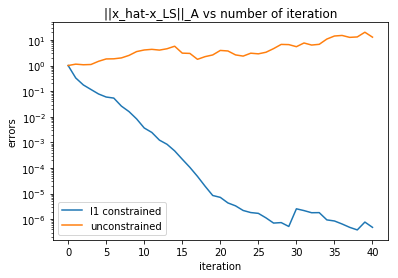

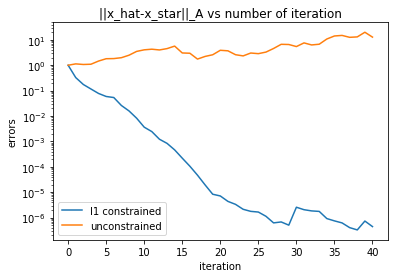

In [54]:
# compare: unconstrained vs l1 constrained

d = 32   # number of cols of A
s = np.ceil(2*np.sqrt(d))   # sparsity of true vector x*
n = int(100*s*np.log(np.exp(1)*d/s)) # number of rows of A
# gamma = 5
# m = int(np.ceil(gamma*s*np.log(d)))
m = int(4*s*np.log(np.exp(1)*d/s))  # sketch size
N = 40    # number of Hessian sketch iterations

A = np.random.randn(n,d)
x_star = sp.sparse.random(d,1, density=s/d).toarray().reshape(d)
x_star = x_star/LA.norm(x_star,2)
y = A@x_star #+ np.random.randn(n)
x_LS_un = LA.solve(A.T@A,A.T@y)

R = sum(abs(x_star))   # l1 norm constraint of x
cons_l1norm = ({'type': 'ineq', 'fun': lambda x:  R-sum(abs(x))})

objective = lambda x: 1/2*LA.norm(A@x-y,2)**2
gradient = lambda x: A.T@(A@x-y)
hessian = A.T@A
res = minimize(fun=objective, x0=np.zeros(d), jac=gradient, constraints=cons_l1norm,method='SLSQP')
x_LS_l1 = res.x

res_l1 = IterHessianSketch(A, y, m, N, cons=cons_l1norm)
x_hat_l1 = res_l1.xt
xts_l1 = res_l1.xts

res_un = IterHessianSketch(A, y, m, N, cons=None)
x_hat_un = res_un.xt
xts_un = res_un.xts

errors_LS_l1 = np.zeros(len(xts_l1))
errors_star_l1 = np.zeros(len(xts_l1))
errors_LS_un = np.zeros(len(xts_un))
errors_star_un = np.zeros(len(xts_un))
                          
for t in range(len(xts_l1)):
    xt = xts_l1[t]
    errors_LS_l1[t] = LA.norm(A@(xt-x_LS_l1),2)/np.sqrt(n)
    errors_star_l1[t] = LA.norm(A@(xt-x_star),2)/np.sqrt(n)
    xt = xts_un[t]
    errors_LS_un[t] = LA.norm(A@(xt-x_LS_un),2)/np.sqrt(n)
    errors_star_un[t] = LA.norm(A@(xt-x_star),2)/np.sqrt(n)

plt.figure()
plt.plot(errors_LS_l1,label="l1 constrained")
plt.plot(errors_LS_un,label="unconstrained")
plt.legend()
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title('||x_hat-x_LS||_A vs number of iteration')
plt.savefig("error_LS_compare_l1_un_plus.pdf")

plt.figure()
plt.plot(errors_star_l1,label="l1 constrained")
plt.plot(errors_star_un,label="unconstrained")
plt.legend()
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title('||x_hat-x_star||_A vs number of iteration')
plt.savefig("error_star_compare_l1_un_plus.pdf")

In [34]:
def IterClassicalSketch(A, y, m, maxIter, cons):
    """
    This function use iterative classical sketch to solve *unconstrained* least square problem Ax=y.
    A, 2D array, n*d
    y, 1D array, length of n
    maxIter, maximal number of iterations 
    m, scalar, number of rows of sketch matrix S
    
    Algorithm:
    1. initialize x(0) = 0
    2. generate an independent sketch matrix S of size m*n
       x(t+1) = x(t) + argmin_{x} { 1/2||SAx - S(y-Ax(t))||_2^2}
    3. return x(maxIter)

    """
    import numpy as np
    import numpy.linalg as LA
    from scipy.optimize import minimize

    sketch = np.random.randn
    ATy = A.T.dot(y)
    ATA = A.T.dot(A)
    
    [row_A, col_A] = A.shape
    xt = np.zeros(col_A)
    xts = [xt]
    
    for t in range(maxIter):
        S = sketch(m,row_A)
        SA = S@A
        
        objective = lambda x: 1/2*LA.norm(SA@x - S@y,2)**2
        gradient  = lambda x: SA.T@(SA@x - S@y)
        hessian   = SA.T@SA
        res = minimize(fun=objective, x0=np.zeros(col_A), jac=gradient)
        
        delta = res.x
        y = y-A@delta
        xt = xt+delta
        xts.append(np.copy(xt))
#         print(res.message)
    
    res.xt = xt
    res.xts = xts
    
    return res
        

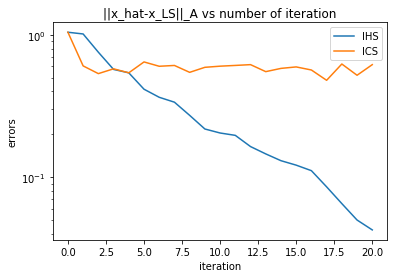

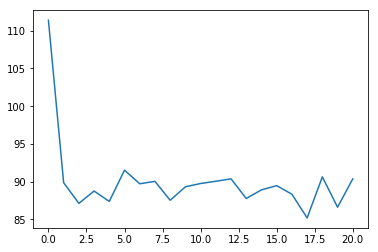

In [39]:
# unconstrained least square: IHS vs ICS(iterative classical sketch)
d = 200   # number of cols of A
n = int(30*d) # number of rows of A

m = int(4*d) # sketch size
N = 40    # number of sketch iterations

A = np.random.randn(n,d)
x_star = np.random.randn(d)
x_star = x_star/LA.norm(x_star,2)
y = A@x_star + np.random.randn(n)
x_LS = LA.solve(A.T@A,A.T@y)

res = IterHessianSketch(A, y, m=m, maxIter=N, cons=None)
x_hat_ihs = res.xt
xts_ihs = res.xts

res = IterClassicalSketch(A, y, m=m, maxIter=N, cons=None)
x_hat_ics = res.xt
xts_ics = res.xts

errors_ihs = np.zeros(len(xts_ihs))
errors_ics = np.zeros(len(xts_ics))
f_ics = np.zeros(len(xts_ics))
for t in range(len(xts_ihs)):
    xt = xts_ihs[t]
    errors_ihs[t] = LA.norm(A@(xt-x_LS),2)/np.sqrt(n)
    xt = xts_ics[t]
    errors_ics[t] = LA.norm(A@(xt-x_LS),2)/np.sqrt(n)
    f_ics[t] = LA.norm(A@xt-y,2)

plt.figure()
plt.plot(errors_ihs,label='IHS')
plt.plot(errors_ics,label='ICS')
plt.legend()
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title('||x_hat-x_LS||_A vs number of iteration')
plt.savefig("error_LS_compare_ihs_ics.pdf")

plt.figure()
plt.plot(f_ics)

In [8]:
def IterHessianSketchPenalty(A, y, m, maxIter, lamb):
    """
    This function use iterative Hessian sketch to solve least square problem Ax=y.
    A, 2D array, n*d
    y, 1D array, length of n
    maxIter, maximal number of iterations 
    m, scalar, number of rows of sketch matrix S
    constr, equality and inequality constraints on x
    
    Algorithm:
    1. initialize x(0) = 0
    2. generate an independent sketch matrix S of size m*n
       x(t+1) = argmin_{x satisfies cons} { 1/2||SA(x-x(t))||_2^2 - < A^T(y-Ax(t)) , x >}
    3. return x(maxIter)
    
    Ref:
    Iterative Hessian Sketch: Fast and Accurate Solution Approximation for Constrained Least-Squares
    Mert Pilanci, Martin J. Wainwright
    http://www.jmlr.org/papers/volume17/14-460/14-460.pdf
    
    """
    import numpy as np
    from scipy.optimize import minimize

    sketch = np.random.randn
#     sketch = Sketch_ROS
    ATy = A.T.dot(y)
    ATA = A.T.dot(A)
    
    [row_A, col_A] = A.shape
    xt = np.zeros(col_A)
    xts = [xt]
    
    for t in range(maxIter):
        S = sketch(m,row_A)
        SA = S@A
        
        objective, gradient, hessian = SubOpt_HessianSketch_Penalty(SA, ATA, ATy, xt, lamb)
        res = minimize(fun=objective, x0=np.zeros(col_A), jac=gradient)

        xt = res.x
        xts.append(np.copy(xt))
#         print(res.message)
    
    res.xt = xt
    res.xts = xts
    
    return res
        

In [ ]:
def SubOpt_HessianSketch_Penalty(SA, ATA, ATy, xt, lamb):
    """
    min_{x} 1/2 || SA(x-xt) ||_2^2 - <AT*y-ATA*xt,x> + lambda*||x||_1
    
    Returns:
    function
        objective function for `scipy.optimize.minimize`
    function
        gradient (jacobian) function for `scipy.optimize.minimize`
    function
        hessian function for `scipy.optimize.minimize`
    
    Ref:
    https://github.com/michaelerule/neurotools/blob/master/stats/glm.py
    GLMPenaltyL2
    """
    import numpy as np
    import numpy.linalg as LA
    
    m = SA.shape[0]
    def objective(x):
        objective = 1/2/m*LA.norm(SA@(x-xt),2)**2 - (ATy-ATA@xt)@(x) + lamb*LA.norm(x,1)
        return objective        
        
    def gradient(x):
        gradient = 1/m*SA.T@SA@(x-xt) - (ATy-ATA@xt) + lamb*np.sign(x)
        return gradient        
        
    hessian = SA.T@SA
    
    return objective, gradient, hessian        
        
    

In [ ]:
# compare: l1 constrained vs l1 penalty
d = 256
n = 8872
s = 32
gamma = 5
m = int(np.ceil(gamma*s*np.log(d)))
N = 20

A = np.random.randn(n,d)
x_star = sp.sparse.random(d,1, density=s/d).toarray().reshape(d)
x_star = x_star/LA.norm(x_star,2)
y = A@x_star + np.random.randn(n)
x_LS = LA.solve(A.T@A,A.T@y)

R = 2*sum(abs(x_star))   # l1 norm constraint of x

cons_l1norm = ({'type': 'ineq', 'fun': lambda x:  R-sum(abs(x))})
res_l1 = IterHessianSketch(A, y, m, N, cons=cons_l1norm)
x_hat_l1 = res_l1.xt
xts_l1 = res_l1.xts

res_pt = IterHessianSketchPenalty(A, y, m, N, lamb = 8)
x_hat_pt = res_pt.xt
xts_pt = res_pt.xts

errors_LS_l1 = np.zeros(len(xts))
errors_star_l1 = np.zeros(len(xts))
errors_LS_pt = np.zeros(len(xts))
errors_star_pt = np.zeros(len(xts))
for t in range(len(xts)):
    xt = xts_l1[t]
    errors_LS_l1[t] = LA.norm(A@(xt-x_LS),2)/np.sqrt(n)
    errors_star_l1[t] = LA.norm(A@(xt-x_star),2)/np.sqrt(n)
    xt = xts_pt[t]
    errors_LS_pt[t] = LA.norm(A@(xt-x_LS),2)/np.sqrt(n)
    errors_star_pt[t] = LA.norm(A@(xt-x_star),2)/np.sqrt(n)

plt.figure()
plt.plot(errors_LS_l1,label="l1 constrained")
plt.plot(errors_LS_pt,label="penalty")
plt.legend()
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title('||x_hat-x_LS||_A vs number of iteration')
plt.savefig("error_LS_compare_l1_pt.pdf")

plt.figure()
plt.plot(errors_star_l1,label="l1 constrained")
plt.plot(errors_star_pt,label="penalty")
plt.legend()
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title('||x_hat-x_star||_A vs number of iteration')
plt.savefig("error_star_compare_l1_pt.pdf")

In [ ]:
def Sketch_ROS(num_row, num_col):
    """
    This function generates a matrix with size num_row*num_col
    num_row < num_col
    """
#------------------------- Haar distribution
#     from scipy.stats import ortho_group
#     import random
    
#     Ortho = ortho_group.rvs(num_col)
#     num = [x for x in range(num_col)]
#     random.shuffle(num)
#     num = num[0:num_row]
#     S = Ortho[[num],]

#------------------------- QR factorization
    import random
    import numpy as np
    from numpy.random import randn
    from numpy.linalg import qr
    
    X = randn(num_col,num_col)
    q, r = qr(X)
    num = [x for x in range(num_col)]
    random.shuffle(num)
    num = num[0:num_row]
    S = q[num,]
    S = np.sqrt(num_col)*S
    
#-------------------------  Hadamard
#     import scipy as sp
#     import numpy as np
    
#     H = sp.linalg.hadamard(num_col)
#     D = np.random.randint(2,size=num_col)
#     D = np.diag(D*2-1)
#     H = H@D
#     num = np.arange(num_col)
#     np.random.shuffle(num)
#     num = num[0:num_row]
#     S = H[num,]
    
    return S